# Installation

In [ ]:
!pip install ccxt
!pip install colab-env -qU

# Imports

In [2]:
import os
import ccxt
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta

In [3]:
import colab_env
from colab_env import envvar_handler

Mounted at /content/gdrive


In [4]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%matplotlib inline

In [6]:
# Constants
CACHE_FILE_NAME = 'btc_ohlcv_cache.csv'
CACHE_PATH = '/content/drive/MyDrive/Colab Notebooks/project_2/data/'
CACHE_FULL_PATH = f'{CACHE_PATH}{CACHE_FILE_NAME}'

# Debug
print(f'full cache path: {CACHE_FULL_PATH}')
# Path('/content/drive/MyDrive/Colab Notebooks/project_2/data/btc_historic.csv')

full cache path: /content/drive/MyDrive/Colab Notebooks/project_2/data/btc_ohlcv_cache.csv


# CCXT - Kraken - API Config

In [7]:
kraken_public_key = os.getenv("KRAKEN_API_KEY")
kraken_secret_key = os.getenv("KRAKEN_SECRET_KEY")

In [8]:
exchange = ccxt.kraken({
    'apiKey': kraken_public_key, 
    'secret': kraken_secret_key })

In [9]:
# 'rateLimit': 10000,
# 'enableRateLimit': True

# btc_latest = kraken.fetch_ticker("BTC/USD")
# btc_latest
# kraken.fetch_ohlcv('BTC', '1h', since=None, limit=None)

# Functions

In [10]:
def fetch_OHLCV_API(ticker, timeframe, since):

  btc_ohlcv = []

  while since < exchange.milliseconds ():

    # Page size
    limit = 20
    day_in_ms = 86400000

    # Fetch paged data 
    ohlcv_page = exchange.fetch_ohlcv(ticker, timeframe, since)

    if len(ohlcv_page):
      
      # Update since - last item in page + 86400000
      since = ohlcv_page[-1][0] + day_in_ms
      
      # Append page
      btc_ohlcv += ohlcv_page
    else:
      break

  # Init df
  btd_df = pd.DataFrame(btc_ohlcv)

  # If no data returned, return None
  if btd_df.shape[0] == 0: return None

  # Rename columns
  btd_df.columns = ['ms', 'open','high','low','close','volume']

  # Parse date
  btd_df['date'] = btd_df['ms'].apply(exchange.iso8601)

  # Set date as index 
  btd_df.set_index(pd.to_datetime(btd_df['date'], infer_datetime_format=True), inplace=True)

  # Drop temp columns
  btd_df.drop(btd_df.columns[6], axis=1, inplace=True)

  return btd_df

In [11]:
def save_cache(path, cache):
  try:
    cache.to_csv(path) 
    return True
  except Exception as e:
    # Log  
    print(f'save_cache - error - {e}')
    return False

In [12]:
def load_cache(path):
  
  # Check file exists
  if os.path.isfile(path):
    
    # Init df using date index
    df = pd.read_csv(
        Path(path),
        index_col="date",
        infer_datetime_format=True,
        parse_dates=True)
    
    # Drop unnecessary data
    # df.drop(df.columns[0], axis=1, inplace=True)

    # Log
    print(f'Cache found. {df.shape[0]} records. Most recent: {df.index[-1]}.')

    return df

  else:

    # Log  
    print(f'Cache not found.')

    return None

In [13]:
def fetch_OHLCV(ticker, timeframe):
  return True

# Load cache and fetch latest

In [14]:
# Load cache from disk
cache = load_cache(CACHE_FULL_PATH)

Cache found. 67 records. Most recent: 2021-03-21 00:00:00+00:00.


In [15]:
# If there is no cache, init with 60 days of data
if cache is None: 

  # Get datetime - today minus 60 days
  cache_start_datetime = datetime.today() - timedelta(days=60)

  # Convert to milliseconds
  cache_start_ms = cache_start_datetime.timestamp() * 1000

  # Log 
  print(f'Cache is empty. Initializing with data starting from {cache_start_datetime}.')

  # Init cache with 60d of data
  cache = fetch_OHLCV_API('BTC/USD', '1d', cache_start_ms)

  # Save cache to disk
  save_cache(CACHE_FULL_PATH, cache)

else:

  # Debug
  print(f'Cache found. {cache.shape[0]} records.')

  # Get cache end date in ms 
  end_date_ms = cache.iloc[-1, 0] + 86400000

  # Call API for latest data
  latest = fetch_OHLCV_API('BTC/USD', '1d', end_date_ms)

  if not latest is None: 

    # Log 
    print(f'Fetching latest data. Adding {latest.shape[0]} records.')

    # Append latest data
    cache = cache.append(latest, ignore_index=False)

    # Save cache to disk
    save_cache(CACHE_FULL_PATH, cache)

  # Log 
  print(f'Total {cache.shape[0]} records.')

Cache found. 67 records.
Fetching latest data. Adding 2 records.
Total 69 records.


In [16]:
latest

,ms,open,high,low,close,volume
date,,,,,,
2021-03-22 00:00:00+00:00,1616371200000,57368.8,58403.2,53775.0,54095.1,6156.277732
2021-03-23 00:00:00+00:00,1616457600000,54098.2,55814.9,53011.0,54460.1,4912.926889


In [17]:
cache.tail(50)

,ms,open,high,low,close,volume
date,,,,,,
2021-02-02 00:00:00+00:00,1612224000000,33534.1,36000.0,33462.1,35500.0,6824.954721
2021-02-03 00:00:00+00:00,1612310400000,35500.0,37676.0,35394.8,37670.9,7014.219793
2021-02-04 00:00:00+00:00,1612396800000,37676.0,38735.1,36202.0,36979.0,7172.513032
2021-02-05 00:00:00+00:00,1612483200000,36975.8,38340.0,36582.9,38296.7,4809.542803
2021-02-06 00:00:00+00:00,1612569600000,38311.7,40986.0,38221.4,39257.0,9126.767296
2021-02-07 00:00:00+00:00,1612656000000,39257.0,39704.4,37410.5,38874.9,5135.540037
2021-02-08 00:00:00+00:00,1612742400000,38867.1,46727.2,38075.0,46425.8,13678.903879
2021-02-09 00:00:00+00:00,1612828800000,46425.7,48222.0,45050.0,46502.8,10574.217717
2021-02-10 00:00:00+00:00,1612915200000,46504.5,47340.0,43734.8,44847.5,6451.558931


# Generate signals

In [18]:
def calc_ema_alert(row):
  if row['ema_signal'] == 1 :
    return 'EMA 30/60 crossover, potential long position'
  if row['ema_signal'] == -1:
    return 'EMA 30/60 crossover, potential short position'
  return ''

In [19]:
def calc_bollinger_alert(row):
  if row['bollinger_signal'] == 1 :
    return 'Bollinger 30 day crossover, potential long position'
  if row['bollinger_signal'] == -1:
    return 'Bollinger 30 day crossover, potential short position'
  return ''

In [20]:
def get_trading_signals_df(ohlcv_df):

  # Trading signal params
  short_window = 30
  long_window = 60
  bollinger_window = 30

  # Make copy of df and drop nulls
  btc_ohlcv = ohlcv_df.copy().dropna()

  # Calculate daily returns
  btc_ohlcv['daily_return'] = btc_ohlcv['close'].pct_change()

  # Need to init calculated fields
  btc_ohlcv["ema_chg"] = 0.0
  btc_ohlcv["ema_signal"] = 0.0
  btc_ohlcv["ema_alert"] = ''

  # Calculate exponential moving average  
  btc_ohlcv["ema_30"] = btc_ohlcv["close"].ewm(halflife=short_window).mean()
  btc_ohlcv["ema_60"] = btc_ohlcv["close"].ewm(halflife=long_window).mean()
  btc_ohlcv["ema_chg"][short_window:] = np.where(btc_ohlcv["ema_30"][short_window:] > btc_ohlcv["ema_60"][short_window:], 1.0, 0.0)
  btc_ohlcv["ema_signal"] = btc_ohlcv["ema_chg"].diff()
  btc_ohlcv["ema_alert"] = btc_ohlcv.apply(lambda row: calc_ema_alert(row), axis=1)

  # Calculate rolling mean and standard deviation
  btc_ohlcv['bollinger_mid_band'] = btc_ohlcv['close'].rolling(window=bollinger_window).mean()
  btc_ohlcv['bollinger_std'] = btc_ohlcv['close'].rolling(window=20).std()

  # Calculate upper and lowers bands of bollinger band
  btc_ohlcv['bollinger_upper_band'] = btc_ohlcv['bollinger_mid_band'] + (btc_ohlcv['bollinger_std'] * 1)
  btc_ohlcv['bollinger_lower_band'] = btc_ohlcv['bollinger_mid_band'] - (btc_ohlcv['bollinger_std'] * 1)

  # Calculate bollinger band trading signal
  btc_ohlcv['bollinger_long'] = np.where(btc_ohlcv['close'] < btc_ohlcv['bollinger_lower_band'], 1.0, 0.0)
  btc_ohlcv['bollinger_short'] = np.where(btc_ohlcv['close'] > btc_ohlcv['bollinger_upper_band'], -1.0, 0.0)
  btc_ohlcv['bollinger_signal'] = btc_ohlcv['bollinger_long'] + btc_ohlcv['bollinger_short']

  return btc_ohlcv[['ms','close','daily_return','ema_30','ema_60','ema_chg','ema_signal', 'ema_alert']].dropna()

In [21]:
def get_alerts(signals_df, alert_window):

  # Filter signals based on alert_window and ema_alert
  alerts_df = signals_df.iloc[-alert_window:,:].query('not ema_signal == 0')[['close','ema_alert']]
  alerts_df['datetime'] = alerts_df.index.format()
  alerts_df = alerts_df[['datetime','close','ema_alert']]

  # Convert to list of tuples
  alerts_ls = [tuple(x) for x in alerts_df.to_records(index=False)]

  return alerts_ls

In [22]:
# Get trading signals
btc_signals = get_trading_signals_df(cache)
btc_signals.tail()

# ema_signal:
#   1 is a potential long signal
#   -1 is a potential short signal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ms,close,daily_return,ema_30,ema_60,ema_chg,ema_signal,ema_alert
date,,,,,,,,
2021-03-19 00:00:00+00:00,1616112000000,58101.8,0.007996,48688.931157,47044.382055,1.0,0.0,
2021-03-20 00:00:00+00:00,1616198400000,58091.6,-0.000176,48963.429605,47282.230310,1.0,0.0,
2021-03-21 00:00:00+00:00,1616284800000,57711.7,-0.006540,49217.211320,47504.545382,1.0,0.0,
2021-03-22 00:00:00+00:00,1616371200000,54095.1,-0.062667,49357.848108,47643.662428,1.0,0.0,
2021-03-23 00:00:00+00:00,1616457600000,54460.1,0.006747,49504.077495,47786.176187,1.0,0.0,


Text(0.5, 1.0, 'BTC - Exponentially Weighted Moving Average')

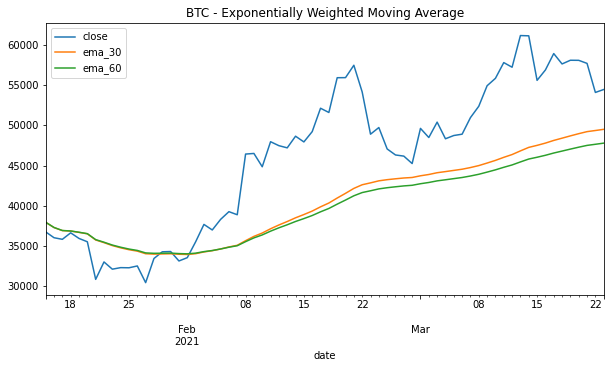

In [23]:
# Plot the EMA of BTC/USD closing prices
btc_ema_fig = btc_signals[['close', 'ema_30', 'ema_60']].plot(figsize=(10,5))
btc_ema_fig.set_title(f'BTC - Exponentially Weighted Moving Average')

In [24]:
# Define alert window
alert_window = 30

# Get 
alerts_ls = get_alerts(btc_signals, 30)
alerts_ls

[]

In [25]:
list_html = '<ul>'
for item in alerts_ls:
  list_html += f'<li>{item[2]}</li>'

list_html += '</ul>'
list_html

'<ul></ul>'

matplotlib.axes._subplots.AxesSubplot

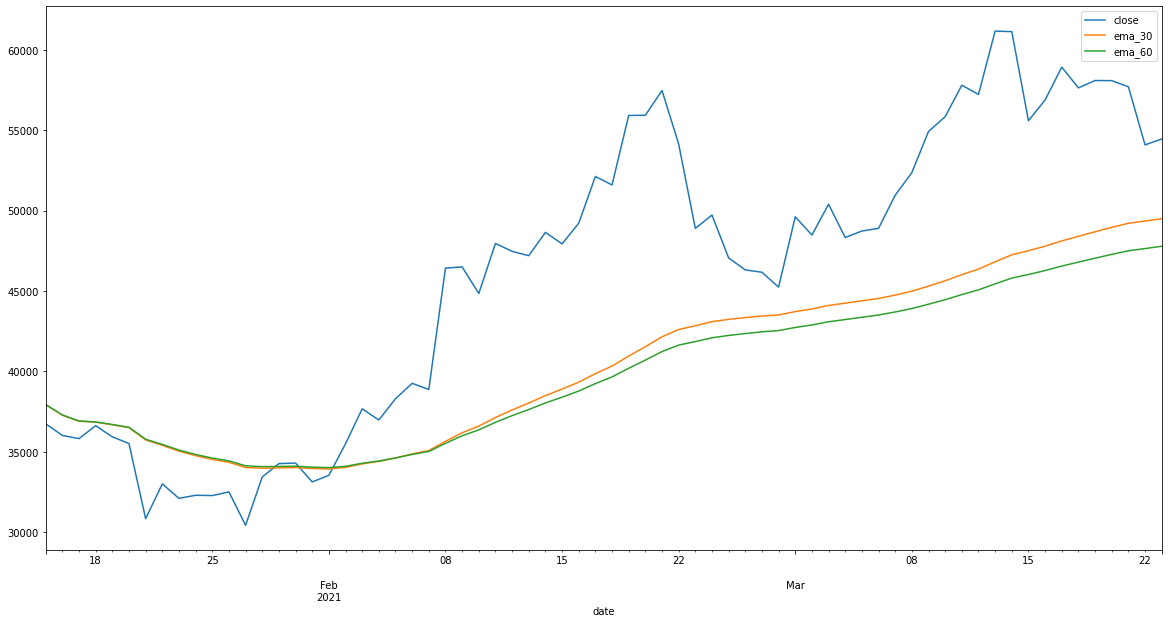

In [26]:
plt = btc_signals[['close', 'ema_30', 'ema_60']].plot(figsize=(20,10))
type(plt)

# Code snippets

In [27]:
# Get all alerts for 60 day window
# Return list of tuple
# alert_window = 60
# alerts_df = btc_signals.iloc[-alert_window:,:].query('not ema_signal == 0')[['close','ema_alert']]
# alerts_df.head()

In [28]:
# alerts_ls = [tuple(x) for x in alerts_df.to_records(index=True)]
# alerts_ls[0][2]

In [29]:
# Plot the EMA of BTC/USD closing prices
# btc_signals[['close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

In [30]:
# # Set bollinger band window
# bollinger_window = 30

# # Calculate rolling mean and standard deviation
# btc_ohlcv['bollinger_mid_band'] = btc_ohlcv['close'].rolling(window=bollinger_window).mean()
# btc_ohlcv['bollinger_std'] = btc_ohlcv['close'].rolling(window=20).std()

# # Calculate upper and lowers bands of bollinger band
# btc_ohlcv['bollinger_upper_band']  = btc_ohlcv['bollinger_mid_band'] + (btc_ohlcv['bollinger_std'] * 1)
# btc_ohlcv['bollinger_lower_band']  = btc_ohlcv['bollinger_mid_band'] - (btc_ohlcv['bollinger_std'] * 1)

# # Calculate bollinger band trading signal
# btc_ohlcv['bollinger_long'] = np.where(btc_ohlcv['close'] < btc_ohlcv['bollinger_lower_band'], 1.0, 0.0)
# btc_ohlcv['bollinger_short'] = np.where(btc_ohlcv['close'] > btc_ohlcv['bollinger_upper_band'], -1.0, 0.0)
# btc_ohlcv['bollinger_signal'] = btc_ohlcv['bollinger_long'] + btc_ohlcv['bollinger_short']

# btc_ohlcv.tail(60)

In [31]:
# Plot the Bollinger Bands for BTC/USD closing prices
# btc_ohlcv[['close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [32]:
    # btc_ohlcv["ema_10"] = btc_ohlcv["close"].rolling(window=short_window).mean()
  # btc_ohlcv["ema_30"] = btc_ohlcv["close"].rolling(window=long_window).mean()
  # btc_ohlcv["ema_chg"][short_window:] = np.where(btc_ohlcv["ema_10"][short_window:] > btc_ohlcv["ema_30"][short_window:], 1.0, 0.0)
  # btc_ohlcv["ema_signal"] = btc_ohlcv["ema_chg"].diff()
  
    # btc_ohlcv['fast_close'] = btc_ohlcv['close'].ewm(halflife=short_window).mean()
  # btc_ohlcv['slow_close'] = btc_ohlcv['close'].ewm(halflife=long_window).mean()
  
  # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
  # btc_ohlcv['fast_close'] = btc_ohlcv['close'].ewm(halflife=short_window).mean()
  # btc_ohlcv['slow_close'] = btc_ohlcv['close'].ewm(halflife=long_window).mean()

  # ,'ema_chg','ema_signal'
  # Return dataframe with full data
  # return btc_ohlcv[['ms','close','daily_return','fast_close','slow_close','crossover_long','crossover_short','crossover_signal',
  #                   'bollinger_upper_band','bollinger_lower_band','bollinger_long','bollinger_short','bollinger_signal']]
  
  # # Construct a crossover trading signal
  # btc_ohlcv['crossover_long'] = np.where(btc_ohlcv['fast_close'] > btc_ohlcv['slow_close'], 1.0, 0.0)
  # btc_ohlcv['crossover_short'] = np.where(btc_ohlcv['fast_close'] < btc_ohlcv['slow_close'], -1.0, 0.0)
  # btc_ohlcv['crossover_sum'] = btc_ohlcv['crossover_long'] + btc_ohlcv['crossover_short']  
  # btc_ohlcv['crossover_signal'] = btc_ohlcv["crossover_sum"].diff()




In [33]:
# Test fetch_OHLCV
# cache_end_date = exchange.parse8601('2021-02-01T00:00:00Z')
# btc_ohlcv = fetch_OHLCV_API('BTC/USD', '1d', cache_end_date)
# btc_ohlcv.head()

In [34]:
# btc_ohlcv.tail()

In [35]:
# Save to cache
# save_cache(CACHE_FULL_PATH, btc_ohlcv)

In [36]:
# Read from disk
# btc_ohlcv_from_disk = load_cache(CACHE_FULL_PATH)
# # if not (btc_ohlcv_from_disk is None):
# btc_ohlcv_from_disk.head()

In [37]:
# cache.tail()

In [38]:
# end_date_ms = cache[['ms']].iloc[-1,:]
# end_date_ms = cache.iloc[-1, 0]
# end_date_ms

In [39]:
# What is time delta?
# cache_start = datetime.today() - timedelta(days=60)
# cache_start
# time_delta = ohlcv_page[1][0] - ohlcv_page[0][0]
# time_delta
# Answer: 86400000 - assumption correct!

In [40]:
# Get last time in page
# ohlcv_page[-1][0]

In [41]:
# Time delta = 86400000 ms = 1d

In [42]:
# https://github.com/ccxt/ccxt/issues/379
# since=int(datetime.datetime.strptime('2017-10-23 00:00:00', '%Y-%m-%d %H:%M:%S').strftime("%s"))
# ohlc=polo.fetch_ohlcv("ETH/BTC", '5m', since)
# Nope, it's not a bug, the library works with all timestamps as milliseconds, everywhere. 
# So, yes, you can just do ohlc=polo.fetch_ohlcv("ETH/BTC", '5m', since * 1000).

In [43]:
# Params
# symbol = 'BTC/USD'
# timeframe = '1h'
# since = exchange.parse8601('2021-03-01T00:00:00Z')  # January

In [44]:
# Fetch OHLCV
# btc_ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since)

In [45]:
# print('First candle of January:', exchange.iso8601(btc_ohlcv[0][0]))
# print('Last candle of January:', exchange.iso8601(btc_ohlcv[-1][0]))
# print('Candles returned:', len(btc_ohlcv))

In [46]:
# Shape df
# btd_df = pd.DataFrame(btc_ohlcv)
# btd_df.columns = ['ms', 'open','high','low','close','volume']
# btd_df['date'] = btd_df['ms'].apply(exchange.iso8601)
# btd_df.set_index(pd.to_datetime(btd_df['date'], infer_datetime_format=True), inplace=True)
# btd_df.drop(btd_df.columns[6], axis=1, inplace=True)
# btd_df.head(100)

In [47]:
# Save to csv
# btc_data = btd_df.to_csv('gdrive/MyDrive/Colab Notebooks/data/btc_ohlcv.csv', index = True) 